In [1]:
!pip install kaggle -q

In [2]:
# importing the dependencies
import os
import json

import zipfile
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
### Data Collection
kaggle_config = json.load(open("kaggle.json"))

In [4]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [5]:
### Set the environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [6]:
### Loading the dataset using kaggle API
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
spotify-million-song-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

Music Recommended System.ipynb
README.md
kaggle.json
spotify-million-song-dataset.zip
spotify_millsongdata.csv


In [8]:
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [9]:
### loading the dataset
df = pd.read_csv('spotify_millsongdata.csv')

In [10]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [12]:
### Understanding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [13]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [14]:
### Top artist and songs
top_artists = df['artist'].value_counts().head(10)
print(top_artists)

artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [15]:
df = df.sample(10000, random_state=42)
df = df.drop('link', axis=1).reset_index(drop=True)

In [16]:
df.shape

(10000, 3)

In [18]:
df.head()

,artist,song,text
0,Wishbone Ash,Right Or Wrong,Like to have you 'round \r\nWith all the lies...
1,Aerosmith,This Little Light Of Mine,"This Little Light of Mine (Light of Mine), \r..."
2,Fall Out Boy,"Dance, Dance",She says she's no good with words but I'm wors...
3,Janis Joplin,Easy Rider,"Hey mama, mama, come a look at sister, \r\nSh..."
4,Moody Blues,Peak Hour,I see it all through my window it seems. \r\n...


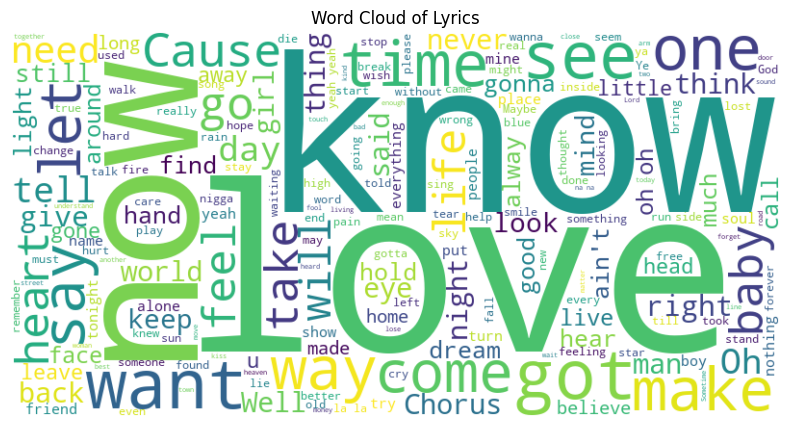

In [20]:
### Word Cloud to visualize the most common words in the lyrics
all_lyrics = ' '.join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lyrics')
plt.show()

In [21]:
### Data Preprocessing
stopwords = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(tokens)

In [23]:
### Apply the preprocessing function to the lyrics column
df['cleaned_text'] = df['text'].apply(preprocess_text)
df.head()

,artist,song,text,cleaned_text
0,Wishbone Ash,Right Or Wrong,Like to have you 'round \r\nWith all the lies...,like round lies make things darkness people sa...
1,Aerosmith,This Little Light Of Mine,"This Little Light of Mine (Light of Mine), \r...",little light mine light mine im let shine alei...
2,Fall Out Boy,"Dance, Dance",She says she's no good with words but I'm wors...,says shes good words im worse barely stuttered...
3,Janis Joplin,Easy Rider,"Hey mama, mama, come a look at sister, \r\nSh...",hey mama mama come look sister shes astanding ...
4,Moody Blues,Peak Hour,I see it all through my window it seems. \r\n...,see window seems never failing like millions e...


In [24]:
### Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [25]:
### Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim.shape)

(10000, 10000)


In [26]:
### Recommendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    idx = df[df['song'].str.lower() == song_name.lower()].index

    if len(idx) == 0:
        return "Song not found in the dataset."
    idx = idx[0]

    sim_idx = list(enumerate(cosine_sim[idx]))
    sim_idx = sorted(sim_idx, key=lambda x: x[1], reverse=True)[1:top_n+1]

    song_indices = [i[0] for i in sim_idx]

    return df[['artist', 'song']].iloc[song_indices]

In [27]:
df["song"][2]

'Dance, Dance'

In [28]:
### Example Recommendation
song_name = df["song"][2]
recommended_songs = recommend_songs('Dance, Dance')
print(recommended_songs)

              artist             song
4174       New Order     Transmission
1501       Halloween  Halloween Dance
8594      Pretenders           Dance!
78           Extreme  Decadence Dance
6079  Michael Bolton    Dance With Me
